<a href="https://colab.research.google.com/github/aiml40/engr521/blob/main/Project_pytorchR3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks with PyTorch

## Import libraries

First, let's install and import the PyTorch libraries we'll need.

In [2]:
# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss, Module
from torch.utils.data import DataLoader, TensorDataset, Subset

# Other libraries we'll use
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pickle
from PIL import Image
from tqdm import tqdm
from pathlib import Path
%matplotlib inline

print("Libraries imported - ready to use PyTorch", torch.__version__)
##Activate GPU if avaiable
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
print("^^^^ if cuda is printed, we are using the GPU!")

Libraries imported - ready to use PyTorch 2.6.0+cu124
cuda
^^^^ if cuda is printed, we are using the GPU!


## Explore the data

In this exercise, you'll train a CNN-based classification model that can classify images of geometric shapes. Let's take a look at the classes of shape the model needs to identify.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def open_pickle_file(file_path):
    """
    Opens and reads  pickle file

    Args:
        file_path (str): The path to the pickle file.

    Returns:
        object: The Python object stored in the pickle file, or None if an error occurs.
    """
    try:
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
            return data
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# Example usage
#file_path = '/content/drive/MyDrive/data/dataset.pkl'
#file_path = '/content/drive/MyDrive/engr521_dataset/dataset.pkl'

file_path = '/content/drive/MyDrive/engr521_dataset/dataset_Haar_Full.pkl'
xs,ys = open_pickle_file(file_path)

if xs.any():
    print("Data loaded successfully:")
    print(xs.shape,ys.shape)
#reshape
# a,b,c = xs.shape
# xsTV = xs.reshape(a,1,b,c)
# print (xsTV.shape)

Data loaded successfully:
(20010, 1, 256, 256) (20010, 2)


In [4]:
def load_batchdataset (x,y,batch_size, testfraction):


  """
  Opens and reads  pickle file

    Args:
        x (numpy array): Features array.
        y (numpy array): labels and  defect size array.
        batch_size (int): batch size
        testfraction(real): % data for testing

    Returns:
        train_loader: Pytorch loader
        test_loader : Pytorch loader.
  """

  # Split into training and testing datasets
  xsT, xsV, ysT, ysV = train_test_split(x, y, test_size=testfraction, random_state=42)

  # === Training data ====

  X_train = torch.from_numpy(xsT).float()
  y_train = torch.from_numpy(ysT[:,0]).float()
  y_train_defectsize = torch.from_numpy(ysT[:,1]).float()

  # === Testing data ====

  X_test = torch.from_numpy(xsV).float()
  y_test = torch.from_numpy(ysV[:,0]).float()
  y_test_defectsize = torch.from_numpy(ysV[:,1]).float()

  print(f"X_train type: {type(X_train)}")
  print(f"X_train size: {X_train.size(),X_train.shape}")
  print()
  print(f"y_train type: {type(y_train)}")
  print(f"y_train size: {y_train.size(),y_train.shape}")
  print()
  print(f"y_train defect type: {type(y_train_defectsize)}")
  print(f"y_train defect  size: {y_train_defectsize.size(),y_train_defectsize.shape}")

  # Use data tensors to build PyTorch Datasets.
  train_dataset = TensorDataset(X_train, y_train, y_train_defectsize)
  test_dataset = TensorDataset(X_test, y_test, y_test_defectsize)

  # Use Datasets to build PyTorch DataLoaders.

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

  # Note: DataLoaders are iterable, where each iteration yields a batch of data.
  # Grab the first batch from the training loader to see dimensions.
  batch_images, batch_labels, batch_damage = next(iter(train_loader))
  print(f"batch_images size: {batch_images.size()}")
  print(f"batch_labels size: {batch_labels.size()}")
  print(f"batch_ldamage size: {batch_damage.size()}")
  return train_loader,test_loader


## Load data



In [5]:
train_loader,test_loader = load_batchdataset (xs,ys,32, 0.3)

X_train type: <class 'torch.Tensor'>
X_train size: (torch.Size([14007, 1, 256, 256]), torch.Size([14007, 1, 256, 256]))

y_train type: <class 'torch.Tensor'>
y_train size: (torch.Size([14007]), torch.Size([14007]))

y_train defect type: <class 'torch.Tensor'>
y_train defect  size: (torch.Size([14007]), torch.Size([14007]))
batch_images size: torch.Size([32, 1, 256, 256])
batch_labels size: torch.Size([32])
batch_ldamage size: torch.Size([32])


## Define the CNN



In [6]:
#works with channels_first format (i.e., shape [batch, channels, height, width]), unlike Keras which defaults to channels_last.
###
class UTModel(nn.Module):
    def __init__(self, w, h, window):
        super(UTModel, self).__init__()
        """
        In CNNs the actual values in the kernels are the weights your network will learn during training: your network will learn what structures are important for prediction.
        With CNN we are no longer flattening our data, so what are our “features”? Our features are called “channels”
        in_channels: how many features are we passing in. Our features are our colour bands, in greyscale, we have 1 feature, in colour, we have 3 channels.
        out_channels: how many kernels do we want to use. Analogous to the number of hidden nodes in a hidden layer of a fully connected network.(How many filters you use in each layer)
        kernel_size: the size of the kernel. e.g. 3x3 (size of the filter)
        stride: the “step-size” of the kernel.
        padding: the number of pixels we should pad to the outside of the image so we can get edge pixels.
        We use “pooling layers” to reduce the shape of our image as it’s passing through the network.
        So when we eventually torch.nn.Flatten(), we’ll have less features in that flattened layer!
        """
        # Shared CNN encoder
        self.features = nn.Sequential(
            # Initial MaxPooling over the "height" dimension
            #If stride is not specified, it defaults to kernel_size
            nn.MaxPool2d((window, 1), stride=(window, 1), padding=0), #reduce the height of our image by dividing it by window(7) as it’s passing through the network (256x256 to 36x256).
            # Conv Block 1
            # First 2D convolutional layer, taking in 1 input channel (image),
            # outputting 96 convolutional features, with a square kernel size of 3
            nn.Conv2d(1, 96, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(96, 64, 3, padding=1),  # 96 input channels, output 64 convulation features with a square kernal size 3.
            nn.ReLU(),
            nn.MaxPool2d((2, 8), padding=(1, 3)), #reduce the image size by dividing it by (2,8) as it’s passing through the network (36x256 to 18x32).
            # Conv Block 2
            nn.Conv2d(64, 48, 3, padding=1), # 64 input channels, output 48 convulation features with a square kernal size 3.
            nn.ReLU(),
            nn.Conv2d(48, 32, 3, padding=1),# 48 input channels, output 32 convulation features with a square kernal size 3.
            nn.ReLU(),
            nn.MaxPool2d((3, 4), padding=(1, 1)) #reduce the image size by dividing it by (3,4) as it’s passing through the network (18x32 to 6 x 8).
        )

        # Flatten
        self.flatten = nn.Flatten()

        # Fully connected shared
        self.shared_fc = nn.Sequential(
            nn.Linear(1792, 14),  # After Pooling layers image size is 6 x 8 and after last conv layer the output channels are 32; 6 x 8 x 32 = 1536
            nn.ReLU()
        )

        # Heads
        self.class_head = nn.Linear(14, 1)  # single output for binary class
        #self.reg_head = nn.Linear(14, 1)    # output for defect size

    def forward(self, x):
        x = self.features(x)
        #print("Shape after CNN:",x.shape)
        x = self.flatten(x)
        #print("Shape after flatten:",x.shape)
        x = self.shared_fc(x)

        class_logit = self.class_head(x)  # for BCEWithLogitsLoss
        #reg_output = self.reg_head(x)
        #return class_logit, reg_output
        return class_logit


In [7]:
def logits_to_sigmoid_probs(logits):
    return torch.sigmoid(logits)  # shape: [batch_size]

def plot_single_prob_vs_defect_size(probs, defect_sizes, title=""):
    plt.figure(figsize=(8, 5))
    plt.scatter(defect_sizes, probs, alpha=0.6, c=probs, cmap='coolwarm')
    plt.xlabel("Defect Size")
    plt.ylabel("Probability of Class 1")
    plt.title(title)
    plt.colorbar(label="Probability")
    plt.grid(True)
    plt.show()

## Train the model


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1


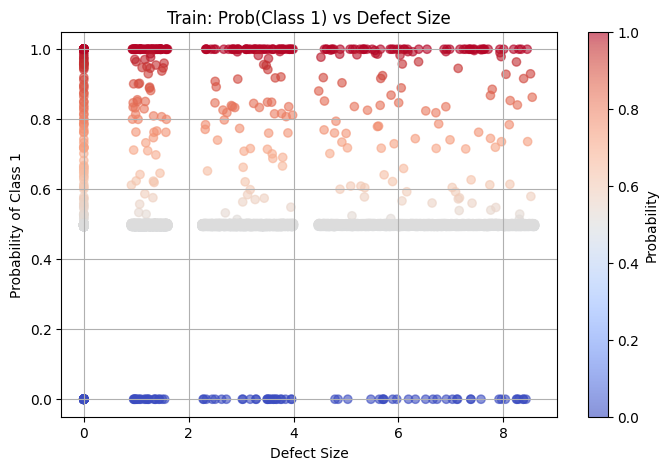

Epochs:  10%|█         | 1/10 [00:15<02:17, 15.25s/it]

Epoch 2


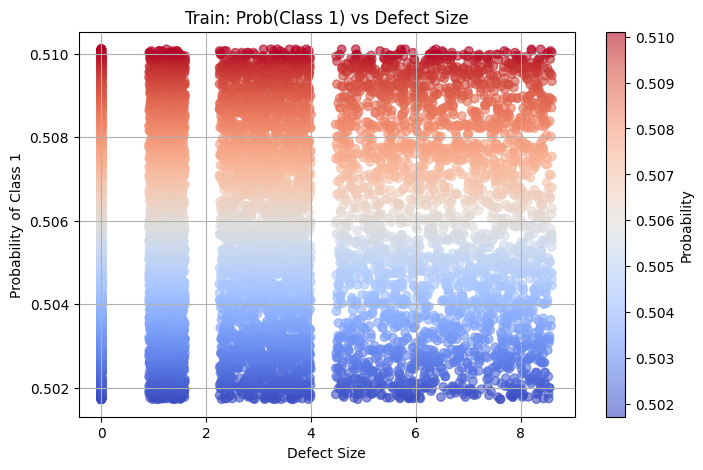

Epochs:  20%|██        | 2/10 [00:29<01:58, 14.75s/it]

Epoch 3


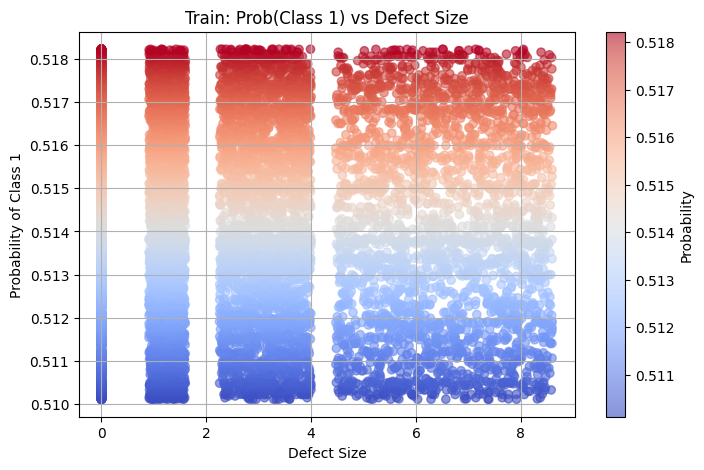

Epochs:  30%|███       | 3/10 [00:44<01:42, 14.65s/it]

Epoch 4


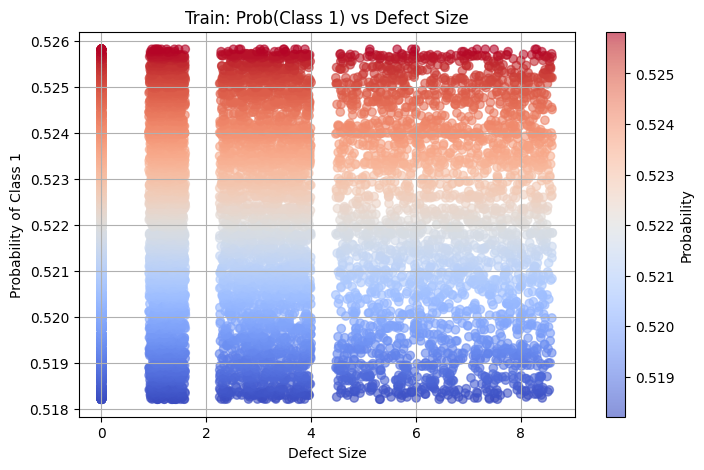

Epochs:  40%|████      | 4/10 [00:58<01:27, 14.64s/it]

Epoch 5


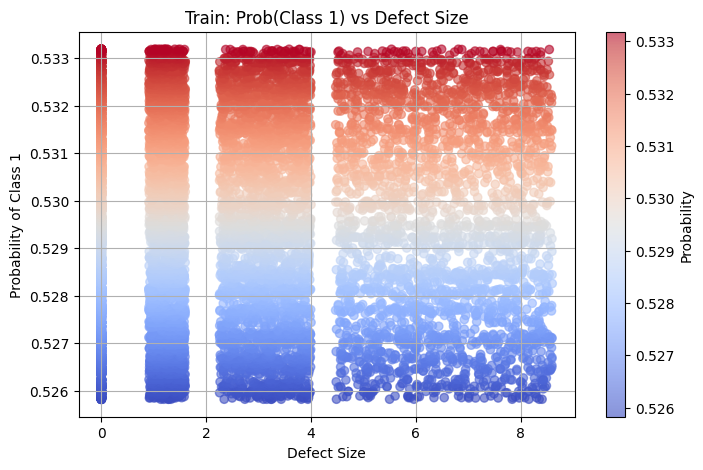

Epochs:  50%|█████     | 5/10 [01:13<01:13, 14.70s/it]

Epoch 6


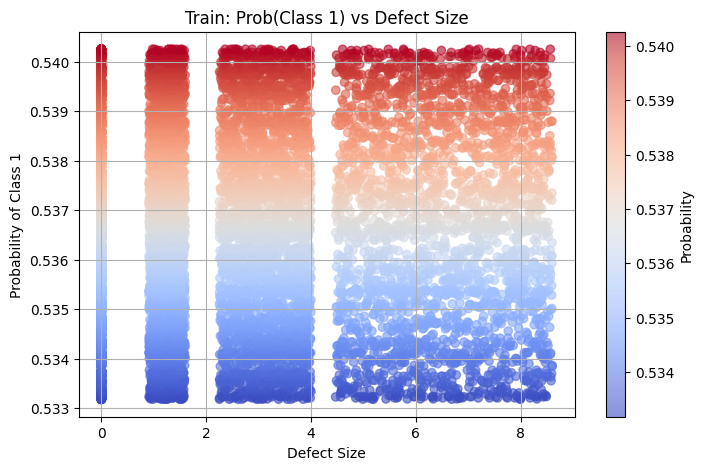

Epochs:  60%|██████    | 6/10 [01:28<00:59, 14.76s/it]

Epoch 7


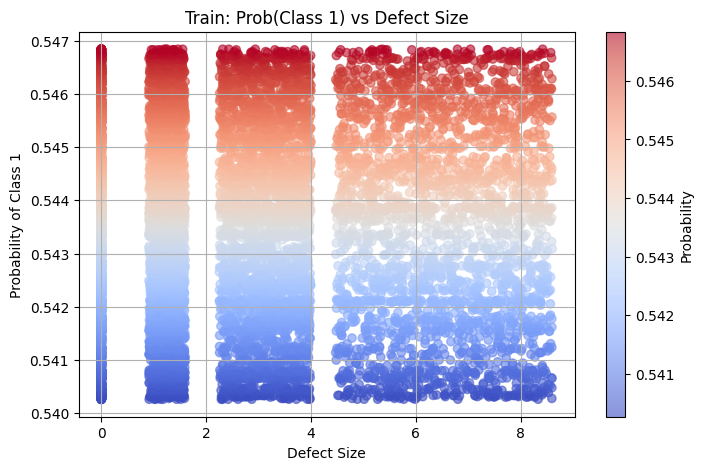

Epochs:  70%|███████   | 7/10 [01:43<00:44, 14.83s/it]

Epoch 8


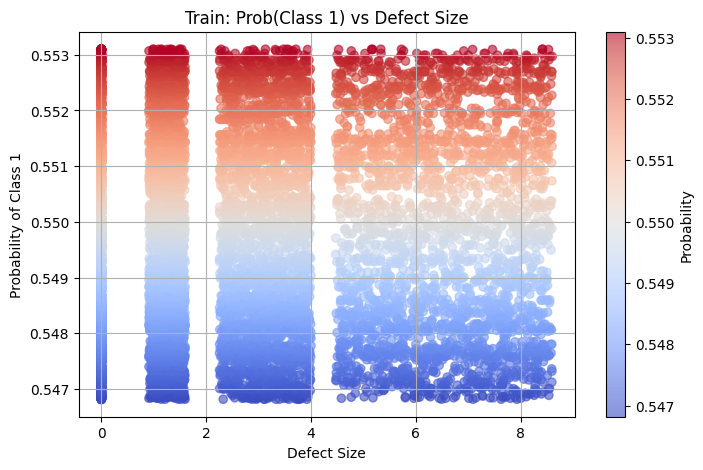

Epochs:  80%|████████  | 8/10 [01:58<00:29, 14.86s/it]

Epoch 9


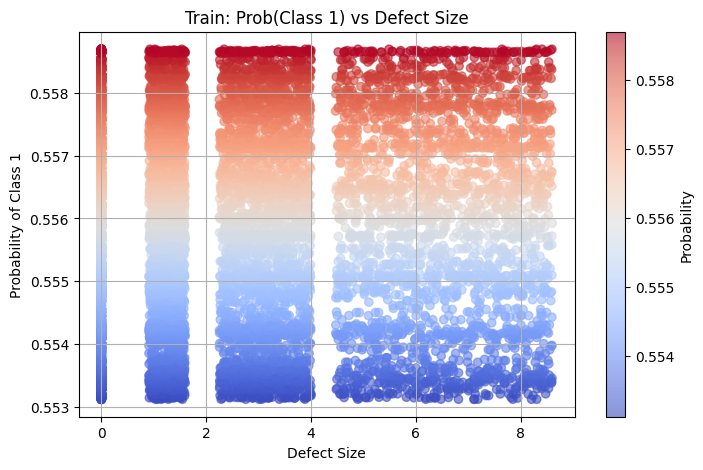

Epochs:  90%|█████████ | 9/10 [02:13<00:14, 14.85s/it]

Epoch 10


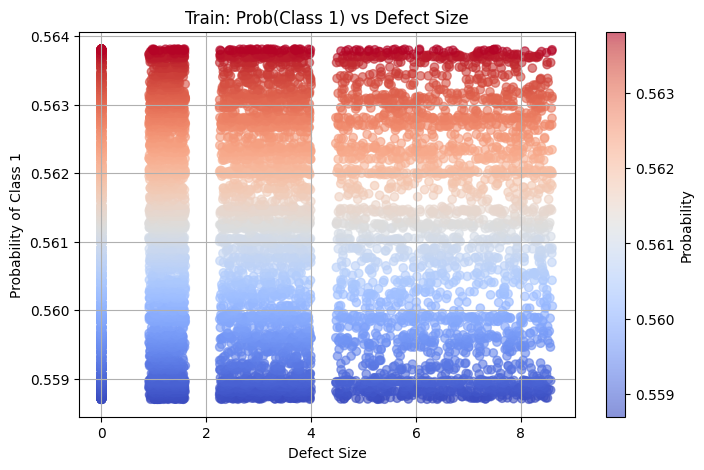

Epochs: 100%|██████████| 10/10 [02:28<00:00, 14.80s/it]


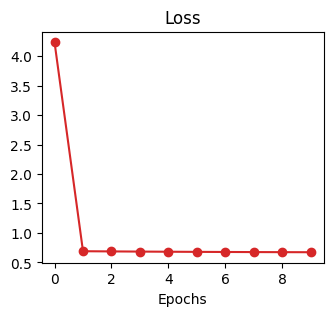

In [8]:

# Initialize the neural network model.
model = UTModel(w = 256,h = 256,window =7 ).to(DEVICE)

# Define the loss function.
loss_func = nn.BCEWithLogitsLoss()  # because we output raw logit

# Define the neural network optimizer.
# Pass the optimizer the NN parameters so that it can update them.
optimizer = optim.RMSprop(model.parameters(), lr=0.0001) # <--- LEARNING RATE MIGHT BE GOOD TO EXPERIMENT WITH

# Record loss and accuracy for every epoch.
all_train_loss = []
all_defects = []
all_prob = []

# Train for some number of epochs.
# Alternatively, train until some accuracy tolerance is met.
num_epochs = 10 # <--- NUMBER OF EPOCHS / CONVERGENCE CONDITIONS MIGHT BE GOOD TO EXPERIMENT WITH
#num_epochs = 100

for epoch in tqdm(range(num_epochs), desc="Epochs"):

    print(f"Epoch {epoch+1}")

    # Prepare the model for training.
    model.train()

    # Initialize this epoch's loss results, defects and probs arrays.
    train_loss = 0.0
    defects = np.empty( (0), dtype='float32')    #  defect lengths
    probs = np.empty((0), dtype='float32')   #  probs data

    # Iterate over all images in the train loader to train the model.
    for images, labels, defect_sizes in train_loader:

        # Load the data onto the GPU.
        images = images.to(DEVICE)
        labels = labels.unsqueeze(1).to(DEVICE)
        optimizer.zero_grad()           # zero the gradient buffers

        #predlabels, preddamage = model(images)            # pass the images through the model
        predlabels = model(images)            # pass the images through the model
        loss = loss_func(predlabels, labels)

        train_loss += loss.item()       # record the loss
        loss.backward()                 # compute gradients
        optimizer.step()                # update the model weights

        # Convert labels to probabilitiy
        train_probs = logits_to_sigmoid_probs(predlabels.squeeze())

        defects = np.concatenate((defects,defect_sizes.cpu().detach().numpy()) )
        probs = np.concatenate((probs,train_probs.cpu().detach().numpy()) )
        #
        #
        #plot_single_prob_vs_defect_size(train_probs.cpu().detach().numpy(), defect_sizes.cpu().detach().numpy(), title="Train: Prob(Class 1) vs Defect Size")


    # Record the average loss across batches for this epoch.
    all_train_loss.append(train_loss / len(train_loader))

    #defects vs probs for current epoch
    plot_single_prob_vs_defect_size(probs, defects, title="Train: Prob(Class 1) vs Defect Size")

    # Add probs and defects for  this epoch.
    all_defects.append(defects)
    all_prob.append(probs)

# Plot the loss and accuracy across epochs.
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(all_train_loss, "o-", c="tab:red")
plt.title("Loss")
plt.xlabel("Epochs")

plt.show()

## View the loss history (See above)

We tracked average training and validation loss for each epoch. We can plot these to verify that loss reduced as the model was trained, and to detect *over-fitting* (which is indicated by a continued drop in training loss after validation loss has levelled out or started to increase).

In [9]:
print("Nothing")

Nothing


## Evaluate model performance



Getting predictions from test set...


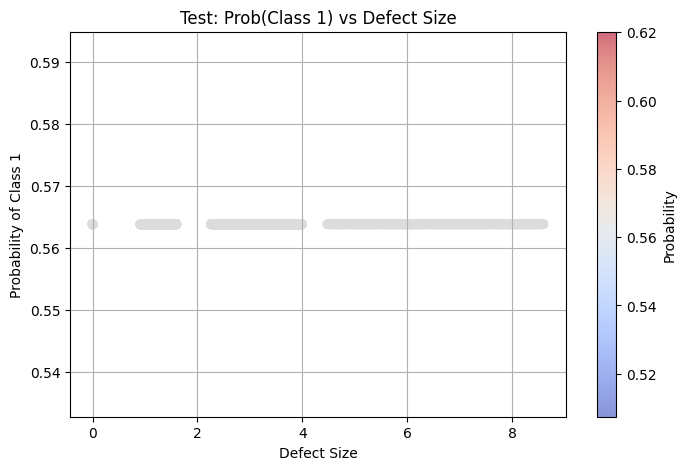

Test results:
Test loss: 0.6766366216730564


'\n# Plot the confusion matrix\ncm = confusion_matrix(truelabels, predictions)\nplt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)\nplt.colorbar()\ntick_marks = np.arange(len(classes))\nplt.xticks(tick_marks, classes, rotation=45)\nplt.yticks(tick_marks, classes)\nplt.xlabel("Predicted Shape")\nplt.ylabel("Actual Shape")\nplt.show()\n'

In [10]:
# Test

# Set the model to evaluate mode
model.eval()

# Get predictions for the test data and convert to numpy arrays for use with SciKit-Learn
print("Getting predictions from test set...")
# Initialize this epoch's loss results, defects and probs arrays.
test_loss = 0.0
defects = np.empty( (0), dtype='float32')    #  defect lengths
probs = np.empty((0), dtype='float32')   #  probs data
# Since we aren't training the model, we make this specification.
with torch.no_grad():
    for images, labels, defect_sizes in test_loader:
      # Load the data onto the GPU.
        images = images.to(DEVICE)
        labels = labels.unsqueeze(1).to(DEVICE)

        #predlabels, preddamage = model(images)            # pass the images through the model
        predlabels = model(images)            # pass the images through the model
        loss = loss_func(predlabels, labels)

        test_loss += loss.item()


        # Convert labels to probabilitiy
        train_probs = logits_to_sigmoid_probs(predlabels.squeeze())

        defects = np.concatenate((defects,defect_sizes.cpu().detach().numpy()) )
        probs = np.concatenate((probs,train_probs.cpu().detach().numpy()) )
        #
    test_loss /= len(test_loader)
    #defects vs probs for current epoch
    plot_single_prob_vs_defect_size(probs, defects, title="Test: Prob(Class 1) vs Defect Size")
print("Test results:")
print("Test loss: " + str(test_loss))
"""
# Plot the confusion matrix
cm = confusion_matrix(truelabels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted Shape")
plt.ylabel("Actual Shape")
plt.show()
"""

## Save the Trained model (Not complete)

Now that you've trained a working model, you can save it (including the trained weights) for use later.

In [ ]:
# Save the model weights
model_file = 'models/shape_classifier.pt'
torch.save(model.state_dict(), model_file)
del model
print('model saved as', model_file)

## Use the trained model (NOT complete)


In [ ]:
import matplotlib.pyplot as plt
import os
from random import randint
%matplotlib inline


# Function to predict the class of an image
def predict_image(classifier, image):
    import numpy

    # Set the classifer model to evaluation mode
    classifier.eval()

    # Apply the same transformations as we did for the training images
    transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Preprocess the image
    image_tensor = transformation(image).float()

    # Add an extra batch dimension since pytorch treats all inputs as batches
    image_tensor = image_tensor.unsqueeze_(0)

    # Turn the input into a Variable
    input_features = Variable(image_tensor)

    # Predict the class of the image
    output = classifier(input_features)
    index = output.data.numpy().argmax()
    return index


# Function to create a random image (of a square, circle, or triangle)
def create_image (size, shape):
    from random import randint
    import numpy as np
    from PIL import Image, ImageDraw

    xy1 = randint(10,40)
    xy2 = randint(60,100)
    col = (randint(0,200), randint(0,200), randint(0,200))

    img = Image.new("RGB", size, (255, 255, 255))
    draw = ImageDraw.Draw(img)

    if shape == 'circle':
        draw.ellipse([(xy1,xy1), (xy2,xy2)], fill=col)
    elif shape == 'triangle':
        draw.polygon([(xy1,xy1), (xy2,xy2), (xy2,xy1)], fill=col)
    else: # square
        draw.rectangle([(xy1,xy1), (xy2,xy2)], fill=col)
    del draw

    return np.array(img)

# Create a random test image
classnames = os.listdir(os.path.join('data', 'shapes'))
classnames.sort()
shape = classnames[randint(0, len(classnames)-1)]
img = create_image ((128,128), shape)

# Display the image
plt.axis('off')
plt.imshow(img)

# Create a new model class and load the saved weights
model = Net()
model.load_state_dict(torch.load(model_file))

# Call the predction function
index = predict_image(model, img)
print(classes[index])

##ADD